### Imports

In [183]:
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import cauchy
from scipy.stats import uniform
from scipy.stats import laplace
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy.integrate import quad, tplquad
from scipy.optimize import curve_fit
import pickle as pkl
from numba import njit, jit, prange, cuda
import numba
import random as rnd
from joblib import Parallel, delayed, parallel_backend #for parallel looping

rng = np.random.default_rng()

## Part 1 -Overdamped Harmonic Oscillator langevin

In [184]:
def simulate_langevin(x0, t, dt, gamma, kT, k):
    seed = np.random.SeedSequence()
    rng = np.random.default_rng(seed)
    steps = int(t/dt) +1
    D = kT/gamma
    x = np.zeros(steps)
    x[0] = x0
    for i in range(1, steps):
        x[i] = x[i-1] - k/gamma * x[i-1] * dt + rng.normal(0,np.sqrt(2*D*dt))
    return x

def simulate_multiple_particles(N, langevin_args):
    steps = int(langevin_args[1]/langevin_args[2])+1
    x = np.zeros((N, steps))
    for i in range(N):
        x[i] = simulate_langevin(*langevin_args)
    return x

In [185]:
if __name__ == "__main__":
    n_particles = 1E5
    kT = 1
    gamma = 1
    t = 10 
    dt = 0.005
    x0 = 0.5
    k = 1
    steps = int(t/dt)
    langevin_args = (x0, t, dt, gamma, kT, k)
    trajectories = Parallel(n_jobs=15, verbose=5)(delayed(simulate_langevin)(*langevin_args) for i in range(int(n_particles)))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=15)]: Done 336 tasks      | elapsed:    0.9s
[Parallel(n_jobs=15)]: Done 3456 tasks      | elapsed:    2.9s
[Parallel(n_jobs=15)]: Done 8640 tasks      | elapsed:    5.8s
[Parallel(n_jobs=15)]: Done 14976 tasks      | elapsed:    9.4s
[Parallel(n_jobs=15)]: Done 22464 tasks      | elapsed:   13.6s
[Parallel(n_jobs=15)]: Done 31104 tasks      | elapsed:   18.5s
[Parallel(n_jobs=15)]: Done 40896 tasks      | elapsed:   24.3s
[Parallel(n_jobs=15)]: Done 51840 tasks      | elapsed:   30.8s
[Parallel(n_jobs=15)]: Done 63936 tasks      | elapsed:   37.9s
[Parallel(n_jobs=15)]: Done 77184 tasks      | elapsed:   45.8s
[Parallel(n_jobs=15)]: Done 91584 tasks      | elapsed:   54.7s
[Parallel(n_jobs=15)]: Done 100000 out of 100000 | elapsed:   59.9s finished


In [186]:
trajectories = np.array(trajectories)
print(trajectories.shape)
np.save("Question_3_data/trajectories.npy", trajectories)

(100000, 2001)


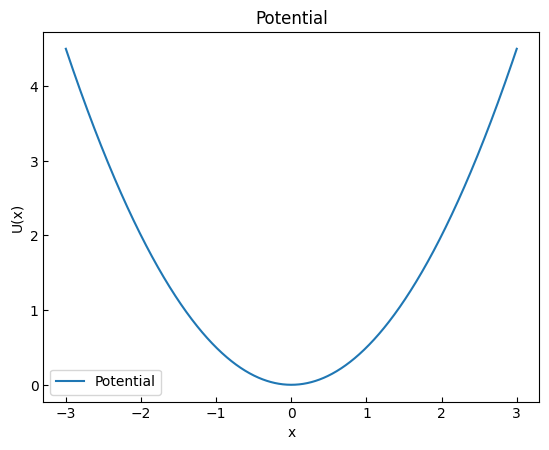

In [187]:
potential = lambda x: 0.5*k*x**2
x_range = np.linspace(-3,3,1000)
plt.plot(x_range, potential(x_range), label='Potential')
plt.xlabel('x')
plt.ylabel('U(x)')
plt.title('Potential')
plt.legend()
plt.tick_params(axis='both', direction='in')
plt.show()

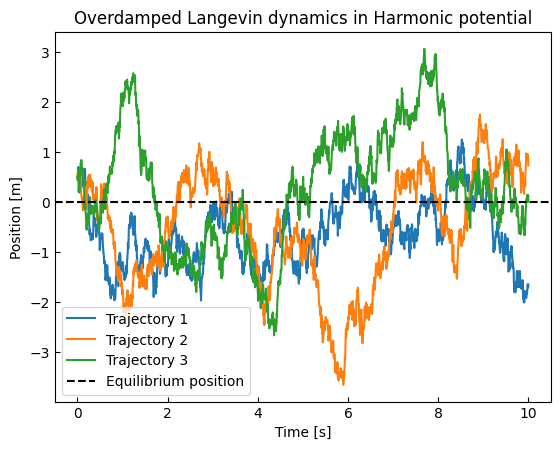

In [188]:
trajectories_to_plot = 3
for i in range(trajectories_to_plot):
    plt.plot(np.linspace(0, t, steps+1), trajectories[i], label='Trajectory '+str(i+1))
plt.axhline(y=0, color='k', linestyle='--', label='Equilibrium position')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Overdamped Langevin dynamics in Harmonic potential')
plt.tick_params(axis='both', direction='in')
plt.legend()
plt.savefig('Question_3_plots/overdamped_langevin_example_trajectories.png')
plt.show()

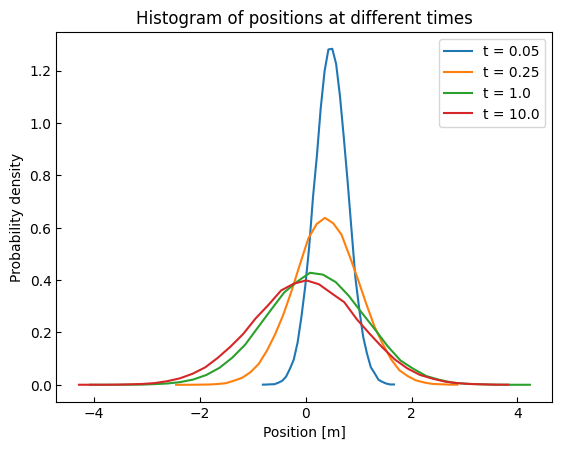

In [199]:
def create_histogram(index, trajectories):
    histogram, bin_edges = np.histogram(trajectories[:,index], bins=35, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    return histogram, bin_centers

time_steps = [10,50,200,2000]
histograms = []
bin_centers = []
for index in time_steps:
    histogram, bins = create_histogram(index, trajectories)
    histograms.append(histogram)
    bin_centers.append(bins)
    plt.plot(bins, histogram, label=f't = {index*dt}')
plt.xlabel('Position [m]')
plt.ylabel('Probability density')
plt.title('Histogram of positions at different times')
plt.legend()
plt.tick_params(axis='both', direction='in')
plt.savefig('Question_3_plots/overdamped_langevin_histograms.png')
plt.show()


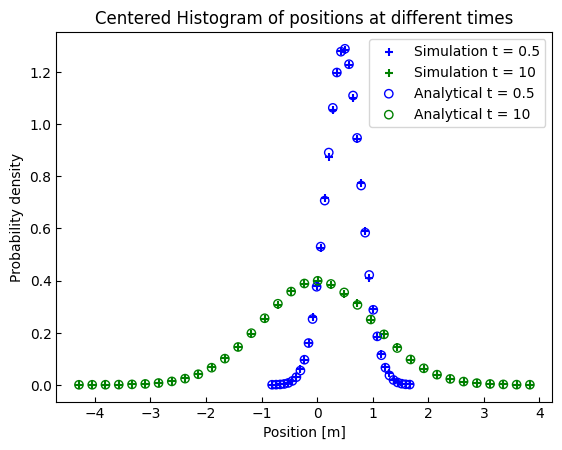

In [201]:
### compare to analytical expression ### 

analytical_var_t = lambda t: kT/(gamma*k)*(1-np.exp(-2*k*t/gamma))
analytical_mean_t = lambda t, x0: x0*np.exp(-k*t/gamma)
t1 = 0.05
t2 = 10
x_range_1 = bin_centers[0]
x_range_2 = bin_centers[3]
gaussian_t1 = norm.pdf(x_range_1, analytical_mean_t(t1, x0), np.sqrt(analytical_var_t(t1)))
gaussian_t2 = norm.pdf(x_range_2, analytical_mean_t(t2, x0), np.sqrt(analytical_var_t(t2)))

plt.scatter(bin_centers[0], histograms[0], label='Simulation t = 0.5', marker='+', facecolors='b')
plt.scatter(bin_centers[3], histograms[3], label='Simulation t = 10', marker='+', facecolors='g')
plt.scatter(bin_centers[0], gaussian_t1, label='Analytical t = 0.5', marker = 'o', facecolors='none', edgecolors='b')
plt.scatter(bin_centers[3], gaussian_t2, label='Analytical t = 10', marker = 'o', facecolors='none', edgecolors='g')
plt.xlabel('Position [m]')
plt.ylabel('Probability density')
plt.title('Centered Histogram of positions at different times')
plt.legend()
plt.tick_params(axis='both', direction='in')
plt.savefig('Question_3_plots/overdamped_langevin_histograms_comparison.png')
plt.show()

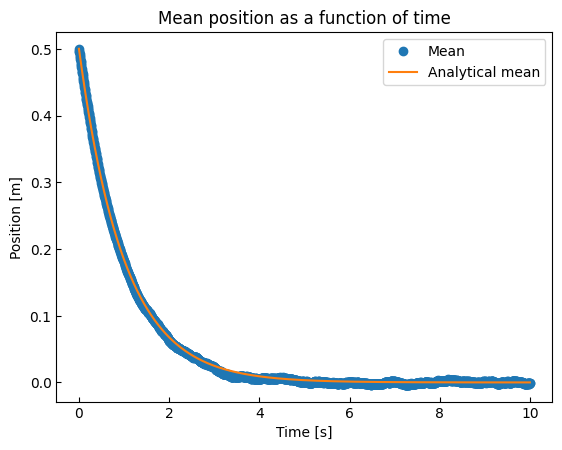

In [202]:
### Moments as a function of time ###
mean_t = np.mean(trajectories, axis=0)
var_t = np.var(trajectories, axis=0)

plt.plot(np.linspace(0, t, steps+1), mean_t, 'o',label='Mean')
plt.plot(np.linspace(0, t, steps+1), analytical_mean_t(np.linspace(0, t, steps+1), x0), label='Analytical mean')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Mean position as a function of time')
plt.tick_params(axis='both', direction='in')
plt.legend()
plt.savefig('Question_3_plots/overdamped_langevin_mean.png')
plt.show()

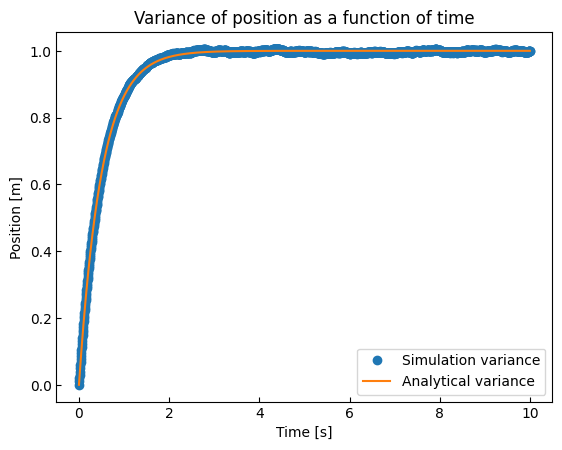

In [203]:
plt.plot(np.linspace(0, t, steps+1), var_t, 'o' ,label='Simulation variance')
plt.plot(np.linspace(0, t, steps+1), analytical_var_t(np.linspace(0, t, steps+1)), label='Analytical variance')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Variance of position as a function of time')
plt.tick_params(axis='both', direction='in')
plt.legend()
plt.savefig('Question_3_plots/overdamped_langevin_variance.png')
plt.show()

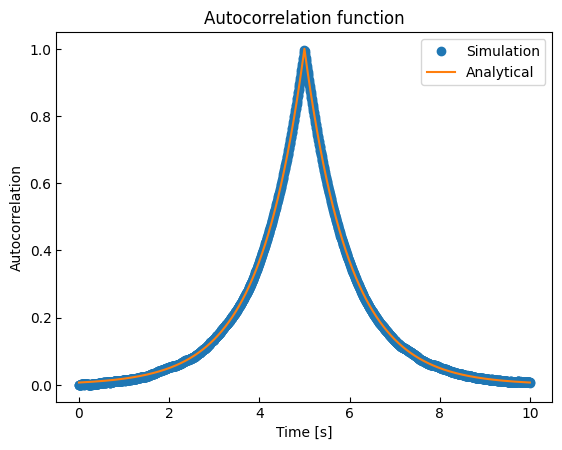

In [204]:
### Calculate Autocorrealtion function ###
def autocorrelation(trajectories, t_tilde):
    x_avg = np.mean(trajectories, axis=0)
    x_avg_t_tilde = np.mean(trajectories[:,t_tilde])

    fluct_t_tilde = trajectories[:,t_tilde] - x_avg_t_tilde

    fluct_x = trajectories - x_avg

    corr = np.mean(fluct_x*fluct_t_tilde[:,None], axis=0)
    return corr

analytical_autocorrelation = lambda t, t_tilde: kT/k * np.exp(-k*abs(t-t_tilde)/gamma)

corr = autocorrelation(trajectories, 1000)
plt.plot(np.linspace(0, t, steps+1), corr, 'o', label='Simulation')
plt.plot(np.linspace(0, t, steps+1), analytical_autocorrelation(np.linspace(0, t, steps+1), 5), label='Analytical')
plt.xlabel('Time [s]')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation function')
plt.tick_params(axis='both', direction='in')
plt.legend()
plt.savefig('Question_3_plots/overdamped_langevin_autocorrelation.png')
plt.show()